# Random Forest Regessor Base Model

## Package imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands
from datetime import datetime as dt
import joblib

## Custom TimedSplit Class

In [2]:
class train_val_split:
    
    def __init__(self, df, duration=30, window=1, prediction_period=5, start = '2018-01-01', end = '2020-03-31'):
        self.duration = duration # training period, for dates
        self.window = window # rolling window freq, for dates
        self.prediction_period = prediction_period # prediciton horizon, for dates
        self.start = start
        self.end = end
        self.df = df.loc[(df.index >= start) & (df.index <= end)].reset_index()
        self.start_ind = self.df[self.df.Date>=self.start].index.min()
        
    @staticmethod
    def _strfdate(date):
        return dt.strftime(date, '%Y-%m-%d')
           
    
    def split_by_date(self):
        self.end_ind = self.start_ind + self.duration
        
        dates = []
        
        while self.end_ind <=  len(self.df) - self.prediction_period:
            date_start = self._strfdate(self.df.Date[self.start_ind])
            date_end = self._strfdate(self.df.Date[self.end_ind])
            
            dates.append([date_start, date_end])
            
            self.start_ind += self.window
            self.end_ind = self.start_ind + self.duration
            
        return dates
    
    def _chk_split(self, date_split):
        for n in range(len(date_split)-1):
            if date_split[n] >= date_split[n+1]:
                return False
        if date_split[0] < self.start:
            return False
        if date_split[-1] > self.end:
            return False
        return True
            
    
    def split_by_index(self, date_split = ['2018-09-30','2019-06-30','2020-03-31']):
        
        if not self._chk_split(date_split):
            return "Check date split again"
        
        ind_out = []            
        for n, date in enumerate(date_split):
            self.train_end_ind = self.df[self.df.Date<=date].index.max()
            
            if n < len(date_split)-1:
                val_end = self.df[self.df.Date<=date_split[n+1]].index.max()
            else:
                val_end = self.df.index.max()
            
            #check boundary_dates
            print(self.df.Date[self.train_end_ind], self.df.Date[self.train_end_ind+1], self.df.Date[val_end])
                
            ind_out.append((list(range(self.start_ind, self.train_end_ind+1)), list(range(self.train_end_ind+1, val_end+1))))
            
        return ind_out
    
    def get_val_map(self, start='2020-06-01', end='2020-12-31'):
        start_ind = self.df[self.df.Date>=start].index.min()
        end_ind = self.df[self.df.Date<=end].index.max()
        
        return {self._strfdate(self.df.Date[n-5]):self._strfdate(self.df.Date[n]) for n in range(start_ind, end_ind+1)}

## Download Data

In [3]:
def get_data(ticker, start="2017-01-01", end="2022-01-01"):
    return yf.download(ticker, start, end)

In [4]:
aapl_data = get_data("AAPL")

[*********************100%***********************]  1 of 1 completed


## Plot the Adjusted Closing Price

In [5]:
def plot_chart(df):
    df['Adj Close'].plot()
    plt.ylabel("Adjusted Close Prices")
    plt.show()

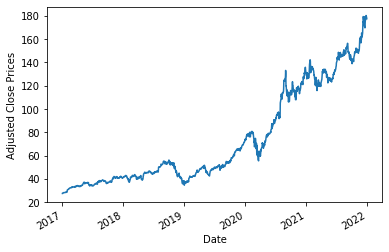

In [6]:
plot_chart(aapl_data)

## % Change Histogram

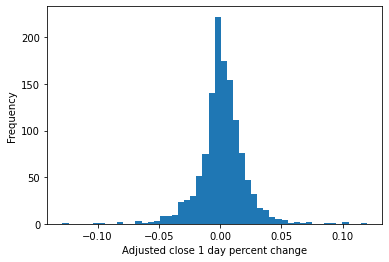

In [7]:
aapl_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

## Add features, target and drop NaN

In [8]:
def add_features_target(df):
    feature_names = []
    # add 14,50,200 day (MA, RSI, BB Width), volume, VIX and append names to feature names
    for n in [14, 50, 200]:
        df[str(n) + 'd' + ' ma'] = SMAIndicator(df['Adj Close'], window=n).sma_indicator()
        df[str(n) + 'd' + ' rsi'] = RSIIndicator(df['Adj Close'], window=n).rsi()
        df[str(n) + 'd' + ' bbwidth'] = BollingerBands(df['Adj Close'], window=n).bollinger_wband()
        feature_names = feature_names + [str(n) + 'd' + ' ma' , str(n) + 'd' + ' rsi', str(n) + 'd' + ' bbwidth']
    
    # add VIX column and to feature_names
    df["VIX"] = get_data("^VIX")["Adj Close"]
    feature_names.append("VIX")
    
    # add target label 5 day future close column 
    df['5d_future_close'] = df['Adj Close'].shift(-5)
    
    # add Volume to feature_names
    feature_names.append("Volume")
    
    # add Adj Close to feature_names
    feature_names.append("Adj Close")
    
    # return completed dataframe and list of feature names
    return df, feature_names

In [9]:
aapl_data, feature_names = add_features_target(aapl_data)

[*********************100%***********************]  1 of 1 completed


## Scale Features

In [10]:
def scale_features(df):
    #Instantiate scaler
    scaler = StandardScaler()
    #fit and transform features
    df[feature_names] = scaler.fit_transform(df[feature_names])
    #Show scaled features
    return df

In [11]:
# Scale features only but not target label
aapl_data = scale_features(aapl_data)

## Splitting into train and test sets chronologically

In [12]:
total_train = aapl_data.loc[(aapl_data.index >= "2018-01-01") & (aapl_data.index <= "2020-12-31")]
X_train = total_train[feature_names]
y_train = total_train['5d_future_close']
total_test = aapl_data.loc[(aapl_data.index >= "2021-01-01") & (aapl_data.index <= "2021-12-23")]
X_test = total_test[feature_names]
y_test = total_test['5d_future_close']

## Train Test Split

In [13]:
split = train_val_split(X_train, end = '2020-12-31')
splits = split.split_by_index()

2018-09-28 00:00:00 2018-10-01 00:00:00 2019-06-28 00:00:00
2019-06-28 00:00:00 2019-07-01 00:00:00 2020-03-31 00:00:00
2020-03-31 00:00:00 2020-04-01 00:00:00 2020-12-31 00:00:00


## Random Grid Search CV

In [14]:
def rf_random_grid_search():
    
    # Trees 
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum samples to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples at each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Instantiate model
    rf = RandomForestRegressor()
    # Random search of parameters with 5 folds
    model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter = 100, cv = splits, verbose=2, random_state=42, n_jobs = -1)
    
    return model

## Train the model

In [15]:
rf_random = rf_random_grid_search()
# Fit
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
                         199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
                         210, 211, 212, 213, 214, 215, 216, 217, ...]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [375, 376, 377, 378, 379, 380, 3...
                   estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                

In [16]:
joblib.dump(rf_random, 'rf_random.joblib')

['rf_random.joblib']

## Base Model Best Parameters and Score

In [17]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

In [18]:
(rf_random.best_score_)

-500.67686855550943

## Predict with X_test and Score for y_test

In [19]:
y_pred = rf_random.predict(X_test)

In [20]:
test_score = metrics.mean_absolute_error(y_test, y_pred)
test_score

14.182333652935615

## Check for 247 rows

In [21]:
len(y_pred) == 247

True

## Create dataframe with actual and predicted y-values

In [22]:
y_values = pd.DataFrame(y_test).rename(columns={"5d_future_close": "Actual"})
y_values['RF_pred'] = y_pred
y_values['Residual'] = y_values["RF_pred"] - y_values["Actual"]
y_values

,Actual,RF_pred,Residual
Date,,,
2021-01-04,128.189713,133.982366,5.792654
2021-01-05,128.010849,130.505458,2.494609
2021-01-06,130.088043,133.982366,3.894323
2021-01-07,128.120163,129.519951,1.399788
2021-01-08,126.361008,130.012704,3.651696
...,...,...,...
2021-12-17,180.330002,133.170698,-47.159304
2021-12-20,179.289993,130.012704,-49.277289
2021-12-21,179.380005,130.992063,-48.387942


In [29]:
y_values.to_csv('rf_random.csv')

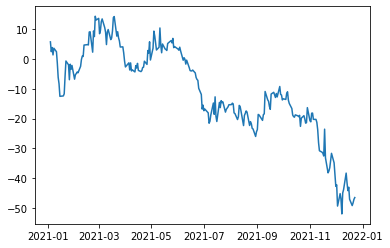

In [23]:
plt.plot(y_values['Residual']);

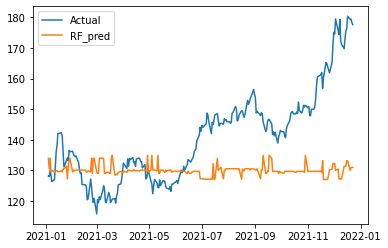

In [24]:
plt.plot(y_values['Actual'], label="Actual")
plt.plot(y_values['RF_pred'], label="RF_pred")
plt.legend()

In [25]:
y_pred_2 = rf_random.predict(X_train)

In [26]:
df = pd.DataFrame(y_train)

In [27]:
df['y_pred_2'] = y_pred_2

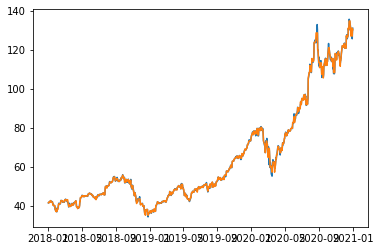

In [28]:
plt.plot(df['5d_future_close'], label="5d_future_close")
plt.plot(df['y_pred_2'], label="y_pred_2")